<a href="https://colab.research.google.com/github/AlexCHEN-Engineer/CEE314HW/blob/main/Problemset3Q4_teaching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CEE 314 Computational Poromechanics, Spring 2022
Instructor : Prof. Ronaldo Borja 

TA: Wei Chen

# Configure the environment in google colab. 
Everyone with goole account can have access to the [google colab](https://colab.research.google.com/). Execute the first cell to get Fenics installed.

In [ ]:
# Do not revise here. 
try:
    import google.colab
except ImportError:
    import ufl
    import dolfin
    import mshr
else:
    try:
        import ufl
        import dolfin
        import mshr
    except ImportError:
        !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
        import ufl
        import dolfin
        import mshr

# Import necessary finite element library
Import necessary finite element library, which includes `dolphin`, `mshr` and `numpy`. Here, `dolphin` is used to execute the finite element operation such as contructing the variational problem, assembling the equations and solve the linear system. `mshr` is a mesh library to deal with the mesh problems. `numpy` is similar to matlab and will only be used to plot the result.

In [ ]:
from dolfin import *
from mshr import *
import numpy as np
import matplotlib.pyplot as plt

## Generate mesh
We use the `Polygon` method to generate the mesh we need for this problem. It is worthwhile to mention that
- The points are sequenced in counter clockwise order.
- The geometry is not a perfect rectangle because of the cofferdam. There is a sharp notch inside the domain.

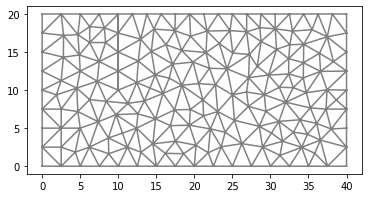

In [ ]:
# Create list of polygonal domain vertices.
eps = 1e-4

# Distribute the point in counter clockwise order.
domain_vertices = [Point(0.0, 0.0),
                   Point(40.0, 0.0),
                   Point(40.0, 20.0),
                   Point(10.0+eps, 20.0),
                   Point(10.0+eps, 10.0),
                   Point(10.0-eps, 20),
                   Point(0, 20),
                   Point(0, 0)]

# Generate mesh and plot.
domain = Polygon(domain_vertices)

# 10 is to adjust the density of mesh
mesh = generate_mesh(domain,10)

# Display the mesh here.
plot(mesh)

# Finite element formulation
In our current problem, the strong form ($S$) is \\
Given  $\bar{q}:\Gamma_q→\mathbb{R}$, find $h:\Omega→\mathbb{R}$ such that
\begin{equation}
\begin{aligned}
& \cal{S}\dot{h} = k\nabla^2 h. \\
& h = 0\quad \text{on} \quad \Gamma_h \\
& k∇h = \bar{q}\quad \text{on} \quad \Gamma_q \\
& h = h_0\quad \text{on}\quad \Omega\quad \text{when}\quad t=0 \\
\end{aligned}
\end{equation}

Recall the trial and weight functions in lectures, where we define:
\begin{equation}
\begin{aligned}
& \cal{T} = \{h|h\in H^1,\ h=0\quad \text{on}\quad \Gamma_h \}, \\
& \cal{W} = \{h|h\in H^1,\ w=0\quad \text{on}\quad \Gamma_h \}.\\
\end{aligned}
\end{equation}
Note that $\Gamma_h$ is the boundary with essential boundary conditions. $\Gamma_q$ is the boundary with natural boundary conditions. $\Gamma_h\cup \Gamma_q=\Gamma$.

Thus, we derive the weak form from the strong form.
\begin{equation}
\begin{aligned}
0 &= \int_{\Omega}\delta h(\cal{S}\frac{\partial h}{\partial t}-k\nabla^2h)dV\\
&= \text{TODO} \\
&= \text{TODO}\\
\end{aligned}
\end{equation}

To run the finite element code, you need to write out the weak form and complete it in the following cell.


In [ ]:
# define the parameters for this problem
S = 10  # coefficient of storage
k = 0.001 # permeability
day2second = 86400. # day to second conversion

T = 200 # unit is day.
num_steps = 200
dt = T / num_steps # unit is second.

In [ ]:
# We select the continuous galerkin family with degree = 1.
V = FunctionSpace(mesh, 'P', 1)

# Define boundary condition in the left of cofferdam.
h_right_cofferdam = Constant(30.)

# Piecewise boundary condition in the right of cofferdam.
h_left_cofferdam = Expression('t<5-DOLFIN_EPS ?-2*t+30:(t<50-DOLFIN_EPS ?\
                      20.:(t<55-DOLFIN_EPS?2*(t-50)+20:30))', degree=1, t = 0)

# Boundary inside the cofferdam.
def boundaryLeftCofferdam(x, on_boundary):
    tol = 1E-14
    return on_boundary and near(x[1], 20, tol) and x[0] < 10.-tol


# Boundary outside the cofferdam.
def boundaryRightCofferdam(x, on_boundary):
    tol = 1E-14
    return on_boundary and near(x[1], 20, tol) and x[0] > 10.+tol


# Define Dirichlet boundary conditions at top boudary.
# It is the stack of two boundaries seperated by cofferdam.
bcs = [DirichletBC(V, h_left_cofferdam, boundaryLeftCofferdam),
       DirichletBC(V, h_right_cofferdam, boundaryRightCofferdam)]

# Define initial value.
h_n = interpolate(h_right_cofferdam, V)

# Define variational problem
# u and v represent the trial function space
# and the weight function space.
h = TrialFunction(V)
v = TestFunction(V)
F = None #TODO
a, L = lhs(F), rhs(F)

# create VTK file for saving solution 
# VTK file can be viewed in paraview. 
# vtkfile = File('CEE314HW3/solution.pvd')

# define the variables to be solved.
h = Function(V)
t = 0
lst = []
p_5 = []
p_50 = []
p_55 = []
for n in range(num_steps):
    t += dt
    h_left_cofferdam.t = t
    solve(a == L, h, bcs)
    if np.abs(t-5.0)<0.01:
      p_5 += [(h(0, x)-x)*9.8 for x in np.linspace(0,20,100)]
    elif np.abs(t-50.0)<0.01:
      p_50 += [(h(0, x)-x)*9.8 for x in np.linspace(0,20,100)]
    elif np.abs(t-55.0)<0.01:
      p_55 += [(h(0, x)-x)*9.8 for x in np.linspace(0,20,100)]
    lst.append(h(0, 5))
    # vtkfile << (u, t)
    # update the history value
    h_n.assign(h)

# Plot the contour of solution.
plot(h)

## Postprocess
Get the pore pressure at point $(0, 5)$ along with the time.

In [ ]:
t = [i+1 for i in range(200)]
elev = np.linspace(0,20,100)
p = [9.8*h for h in lst]
plt.xlabel(r"$t$, day")
plt.ylabel(r"pore pressure, $kPa$")
plt.plot(t, p, 'k')

Plot the pore pressure distribution along midline at $t=5$ day.

In [ ]:
plt.xlabel(r"elevation, $m$")
plt.ylabel(r"pore pressure, $kPa$")
plt.plot(elev, p_5, 'k')

Plot the pore pressure distribution along midline at $t=50$ day.

In [ ]:
plt.xlabel(r"elevation, $m$")
plt.ylabel(r"pore pressure, $kPa$")
plt.plot(elev, p_50, 'k')

Plot the pore pressure distribution along midline at $t=55$ day.

In [ ]:
plt.xlabel(r"elevation, $m$")
plt.ylabel(r"pore pressure, $kPa$")
plt.plot(elev, p_55, 'k')